In [1]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
import numpy as np
from datetime import timedelta, datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data: what happened so far?

**Selection**: what are relevant characteristica?

**Cleaning**: 
- missing values in MODEL: 2
    - using the historical records of that VIN fill in the missing MODEL values
- engineer new feature: MAKE + MODEL + MODEL_YEAR
    - unique MAKE_MODEL_YEAR: 11684
    - total records: 187503
- drop: MODEL, MAKE, ZIP_CODE
- if a vehicle has multiple records from the same date, keep first record
    - records where vehicles got tested more than 1 time a day: 4046
    - after removing repeated tests from same day
        - total number of records: 187503 > 183457 
        - P: 173762 > 170120
        - F: 13741 > 13337
        - data range: 2013-01-01/2020-12-31 
- engineer feature: VEHICLE_AGE
- extract month, weekday, hour from TEST_SDATE: pause!!!
    - testing time ~ testing outcome??   
- drop TEST_SDATE
- map to numeric: TEST_TYPE:{'I':0, 'A':1}, TRANS_TYPE:{'A':0, 'M':1}
- drop VEHICLE_TYPE
    - near 1000 MAKE_MODEL_YEARs had more than 1 VEHICLE_TYPE 
    - it's not clear how vehicle types were defined
- dropped CYL
    - share of fail is higher when CYL is 9, 12 and R
    - but these are very few values
- drop FUEL_TYPE (FUEL_TYPE L only has 4 records and all are Pass)
    - more than 95% of the tests have FUEL_TYPE G
- 0 in GVWR: 11577 (P: 11090, F: 487)
    - set 0 to np.nan
    - fill in missing values using other records having the same VIN
        - left missing values: 7963 (P: 7564, F: 399)
- 0 in ODOMETER: 875 --- excluded!
    - P:    746
    - F:    129

In [2]:
# get original data
data_src = Path("data/sample201320.csv")
df_full = pd.read_csv(data_src, low_memory=False, sep=',')
df_full = df_full[(df_full.OVERALL_RESULT == "F") | (df_full.OVERALL_RESULT == "P")]
df_full['OVERALL_RESULT'].value_counts(normalize=True) * 100

P    92.671584
F     7.328416
Name: OVERALL_RESULT, dtype: float64

In [3]:
# get clean data
data_src = Path("data/clean_data_20210505.csv")
df = pd.read_csv(data_src, low_memory=False, sep=',')
df.shape
df['RESULT'].value_counts(normalize=True) * 100

1    92.655639
0     7.344361
Name: RESULT, dtype: float64

# What are the characteristica?

In [4]:
list(df.columns)

['RecordID',
 'RESULT',
 'TEST_TYPE',
 'ENGINE_SIZE',
 'TRANS_TYPE',
 'ODOMETER',
 'MAKE_MODEL_YEAR',
 'VEHICLE_AGE',
 'GVWR']

## What do we think is important conceptually?
* VEHICLE_AGE
* ODOMETER - sanity check and switch to odometer per year
* ENGINE_SIZE
* GVWR - switch to weight class?

## ODO_YEAR

In [5]:
df['ODO_YEAR'] = df.ODOMETER / df.VEHICLE_AGE
df['ODO_YEAR'][np.isinf(df['ODO_YEAR'])] = df['ODOMETER']

<ipython-input-5-2f2cd1add9e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ODO_YEAR'][np.isinf(df['ODO_YEAR'])] = df['ODOMETER']


In [6]:
count = np.isinf(df['ODO_YEAR']).values.sum()
print ( "It contains " + str (count) + " infinite values" )

It contains 0 infinite values


In [7]:
df.head()

,RecordID,RESULT,TEST_TYPE,ENGINE_SIZE,TRANS_TYPE,ODOMETER,MAKE_MODEL_YEAR,VEHICLE_AGE,GVWR,ODO_YEAR
0,4118828,0,0,1600,0,215161.0,geo/prizm/1991,28,2625.0,7684.321429
1,3716231,1,0,2300,0,156888.0,suzuki/aerio/2004,13,3000.0,12068.307692
2,2643540,1,0,3400,0,124227.0,toyota/4runner 4wd/2001,13,4250.0,9555.923077
3,3870644,1,0,5700,0,66315.0,dodge/ram 1500 2wd/2006,12,6000.0,5526.250000
4,3951493,1,0,2500,0,112471.0,nissan/altima/2010,8,3375.0,14058.875000


In [8]:
min(df['ODO_YEAR'])

0.047619047619047616

In [9]:
max(df['ODO_YEAR'])
# with 70mph you could theoretically drive 613,000 miles per year if you never pause...

1777777.6

In [10]:
df[df['ODO_YEAR'] > 300000]

,RecordID,RESULT,TEST_TYPE,ENGINE_SIZE,TRANS_TYPE,ODOMETER,MAKE_MODEL_YEAR,VEHICLE_AGE,GVWR,ODO_YEAR
293,2915505,1,0,3200,0,8888888.0,acura/tl/2005,10,3750.0,8.888888e+05
3467,3090095,1,0,5900,0,8888888.0,dodge/ram 1500/1996,19,6400.0,4.678362e+05
11054,3676681,1,0,5000,1,8888888.0,ford/mustang/1991,26,3000.0,3.418803e+05
11055,3521352,1,0,2300,1,8888888.0,ford/mustang/1992,25,3125.0,3.555555e+05
12556,3938371,1,0,3800,1,8888888.0,ford/mustang/2001,17,3375.0,5.228758e+05
...,...,...,...,...,...,...,...,...,...,...
150025,2758057,1,0,2200,0,8888888.0,toyota/pickup/1993,21,3700.0,4.232804e+05
157985,4449621,1,0,3500,0,8163604.0,toyota/rav4/2008,12,4720.0,6.803003e+05
168160,4828224,1,0,3000,0,8888888.0,bmw/3-series/2013,8,3500.0,1.111111e+06
168367,2838958,1,0,2800,0,8888888.0,bmw/3-series/2000,14,3500.0,6.349206e+05


In [31]:
# most of these have 8888888.0 and 9999999.0 in the ODOMETER column - mistakes?
# I am removing them
df = df[(df['ODOMETER'] != 8888888) & (df['ODOMETER'] != 9999999)]
df = df[df['ODO_YEAR'] < 200000]
df['RESULT'].value_counts(normalize=True) * 100

1    92.66219
0     7.33781
Name: RESULT, dtype: float64

## We need to figure out a cut-off for ODO_YEAR

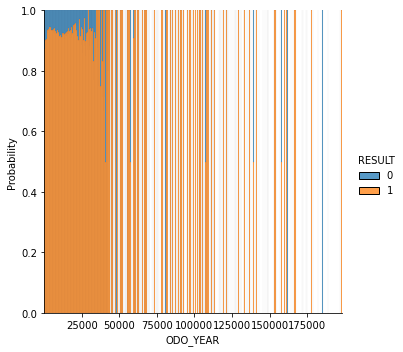

In [13]:
sns.displot(data=df, x='ODO_YEAR', hue='RESULT', multiple='fill', discrete=False, stat='probability')

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

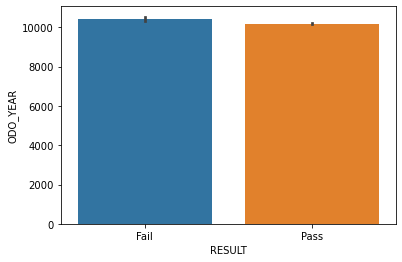

In [14]:
g_ob = sns.barplot(x='RESULT', y='ODO_YEAR', data=df)
g_ob.set(xticklabels=["Fail","Pass"]) 

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

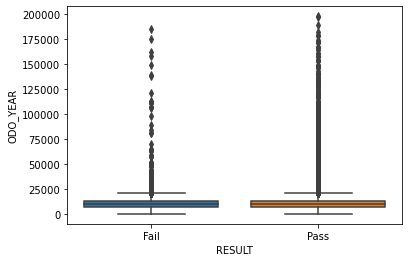

In [15]:
g_o = sns.boxplot(data=df, y='ODO_YEAR', x='RESULT')
g_o.set(xticklabels=["Fail","Pass"]) 

## ODOMETER

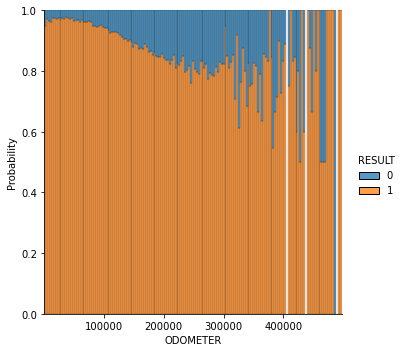

In [16]:
sns.displot(data=df[df['ODOMETER'] < 500000], x='ODOMETER', hue='RESULT', multiple='fill', discrete=False, stat='probability')

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

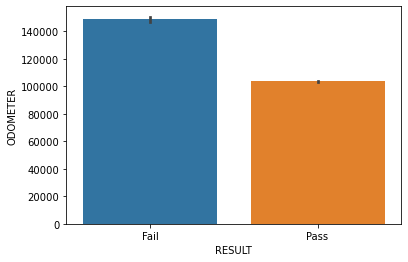

In [17]:
g_ob = sns.barplot(x='RESULT', y='ODOMETER', data=df)
g_ob.set(xticklabels=["Fail","Pass"]) 

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

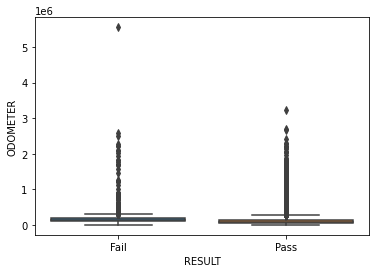

In [18]:
g_o = sns.boxplot(data=df, y='ODOMETER', x='RESULT')
g_o.set(xticklabels=["Fail","Pass"]) 

## VEHICLE_AGE

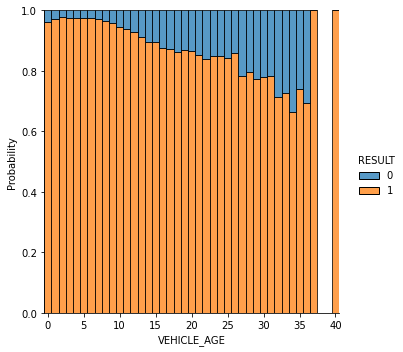

In [19]:
sns.displot(data=df, x='VEHICLE_AGE', hue='RESULT', multiple='fill', discrete=True, stat='probability')

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

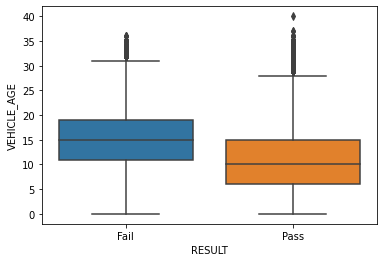

In [20]:
g_a = sns.boxplot(x='RESULT', y='VEHICLE_AGE', data=df)
g_a.set(xticklabels=["Fail","Pass"]) 

## GVWR

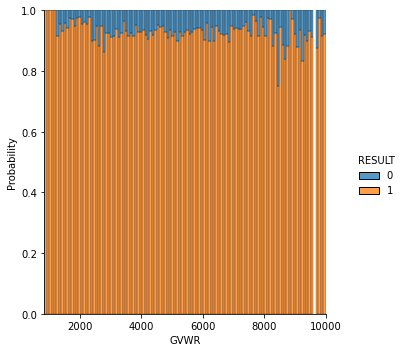

In [21]:
sns.displot(data=df, x='GVWR', hue='RESULT', multiple='fill', discrete=False, stat='probability')

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

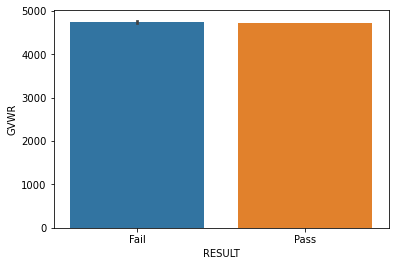

In [22]:
g_w = sns.barplot(x='RESULT', y='GVWR', data=df)
g_w.set(xticklabels=["Fail","Pass"]) 

## ENGINE_SIZE

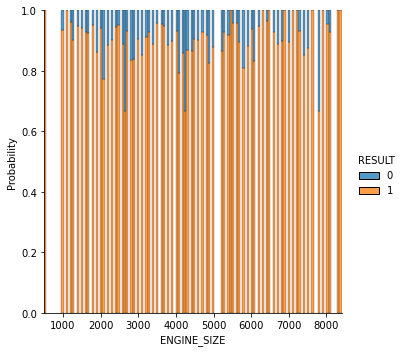

In [23]:
sns.displot(data=df, x='ENGINE_SIZE', hue='RESULT', multiple='fill', discrete=False, stat='probability')

[[Text(0, 0, 'Fail'), Text(1, 0, 'Pass')]]

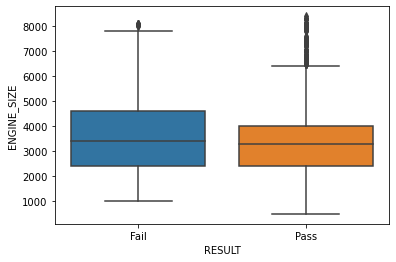

In [24]:
g_e = sns.boxplot(data=df, y='ENGINE_SIZE', x='RESULT')
g_e.set(xticklabels=["Fail","Pass"]) 

# Do any characteristics relate to one another?

## Correlation of our metric variables

<AxesSubplot:>

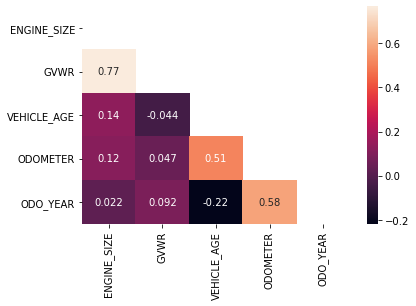

In [25]:
# correlation stuff
cols = ['ENGINE_SIZE', 'GVWR', 'VEHICLE_AGE', 'ODOMETER', 'ODO_YEAR']
df_cor = df[cols].copy()
# show some correlations
matrix = np.triu(df_cor.corr())
sns.heatmap(df_cor.corr(), annot=True, mask=matrix)

## Variance Inflation Factor

In [26]:
# selecting columns
codes, uniques = pd.factorize(df['MAKE_MODEL_YEAR'])
cols = ['RESULT', 'TEST_TYPE', 'ENGINE_SIZE', 'TRANS_TYPE', 'ODOMETER', 'VEHICLE_AGE', 'GVWR']
df_vif = df[cols].copy()
df_vif['MAKE_MODEL_YEAR'] = codes

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i)
                          for i in range(len(df_vif.columns))]
  
print(vif_data)

           feature        VIF
0           RESULT   8.180756
1        TEST_TYPE   1.021057
2      ENGINE_SIZE  21.338848
3       TRANS_TYPE   1.209853
4         ODOMETER   3.868163
5      VEHICLE_AGE   5.850558
6             GVWR  23.902940
7  MAKE_MODEL_YEAR   3.244213


# Probably not so important

## TEST_TYPE
* Initial
* Retest

C:\Users\Oswin\anaconda3\lib\site-packages\seaborn\axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


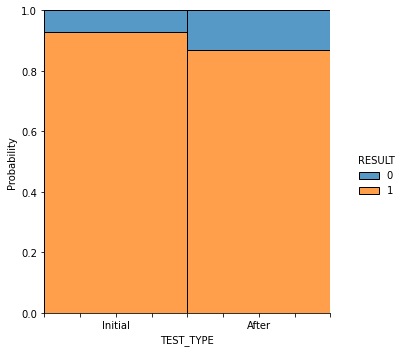

In [27]:
g_tt = sns.displot(data=df, x='TEST_TYPE', hue='RESULT', multiple='fill', discrete=True, stat='probability')
g_tt.set(xticklabels=["","","Initial","","","", "After","",""]) 

## TRANS_TYPE

C:\Users\Oswin\anaconda3\lib\site-packages\seaborn\axisgrid.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


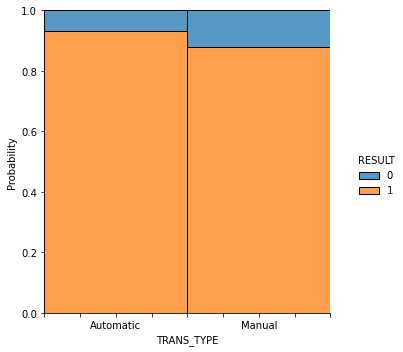

In [28]:
g_t = sns.displot(data=df, x='TRANS_TYPE', hue='RESULT', multiple='fill', discrete=True, stat='probability')
g_t.set(xticklabels=["","","Automatic","","","", "Manual","",""]) 

## MAKE_MODEL_YEAR

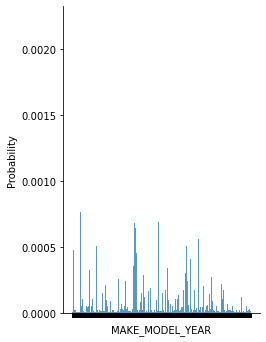

In [29]:
g1 = sns.displot(data=df[df.RESULT == 1], x='MAKE_MODEL_YEAR', discrete=True, stat='probability')
g1.set(xticklabels=[])

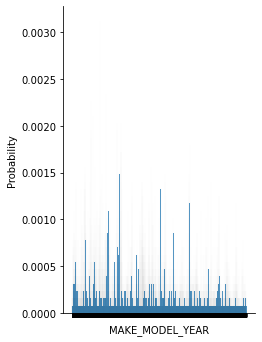

In [30]:
g2 = sns.displot(data=df[df.RESULT == 0], x='MAKE_MODEL_YEAR', discrete=True, stat='probability')
g2.set(xticklabels=[])